# Machine Learning Model To Predict Stock Market

## Getting & Displaying The Data

In [2]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yfin
from datetime import datetime

In [3]:
# Defining the start and end dates of data
start = '2010-01-01'
end = '2023-08-31'

yfin.pdr_override()
df = pdr.get_data_yahoo('AAPL', start, end)    # Can change the ticker here for a different stock
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.487534,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.498749,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.395380,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.383555,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.425995,447610800


In [4]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-08-24,180.669998,181.100006,176.009995,176.380005,176.380005,54945800
2023-08-25,177.380005,179.149994,175.820007,178.610001,178.610001,51449600
2023-08-28,180.089996,180.589996,178.550003,180.190002,180.190002,43820700
2023-08-29,179.699997,184.899994,179.500000,184.119995,184.119995,53003900
2023-08-30,184.940002,187.850006,184.740005,187.649994,187.649994,60813900


## Cleaning

In [5]:
# Reseting the index
df = df.reset_index()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.487534,493729600
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.498749,601904800
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.395380,552160000
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.383555,477131200
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.425995,447610800


In [6]:
# We have 2 close columns, we will choose adj close as it is considered a more accurate representation of the stock
# Dropping the data and close columns and renaming adj close
df = df.drop(['Date', 'Close'], axis = 1)
df = df.rename(columns={'Adj Close': 'Close'})
df.head()

,Open,High,Low,Close,Volume
0,7.622500,7.660714,7.585000,6.487534,493729600
1,7.664286,7.699643,7.616071,6.498749,601904800
2,7.656429,7.686786,7.526786,6.395380,552160000
3,7.562500,7.571429,7.466071,6.383555,477131200
4,7.510714,7.571429,7.466429,6.425995,447610800


## Data Analysis Using Moving Averages

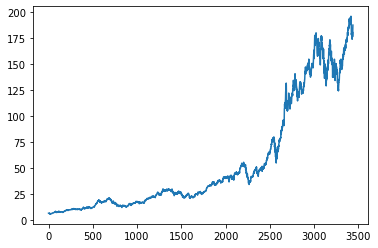

In [7]:
plt.plot(df['Close'])

In [8]:
# With moving averages of 100 and 200, a stock trader can try to predict whether a stock might go up or down
# If the ma100 is above ma200, then the stock will probably go up and vive versa
ma100 = df.Close.rolling(100).mean()
ma200 = df.Close.rolling(200).mean()

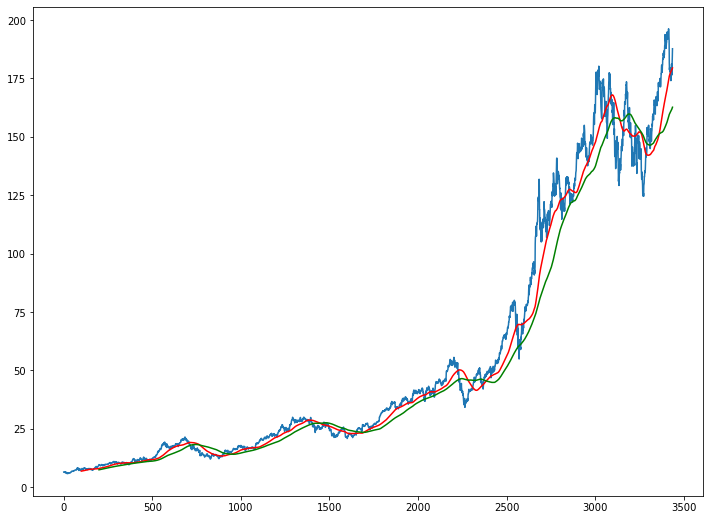

In [9]:
plt.figure(figsize=(12,9))
plt.plot(df['Close'])
plt.plot(ma100, 'r')
plt.plot(ma200, 'g')

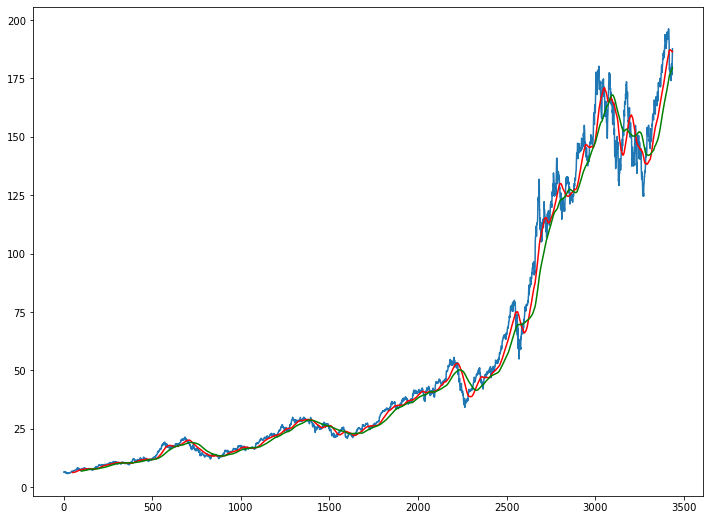

In [10]:
# Here I also tried with ma50 and ma100, it has nearly the same properties with more sensitivity
ma50 = df.Close.rolling(50).mean()

plt.figure(figsize=(12,9))
plt.plot(df['Close'])
plt.plot(ma50, 'r')
plt.plot(ma100, 'g')

## Preprocessing

In [11]:
# Importing libraries for preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [12]:
df.shape

(3438, 5)

In [13]:
# Splitting our data into training and testing sets
closing_data = pd.DataFrame(df['Close'])
closing_data.head()
testing_df = closing_data.tail(638)
training_df = closing_data.head(2800)

print(training_df.shape)
print(testing_df.shape)

(2800, 1)
(638, 1)


In [14]:
# We will use a LSTM model for machine learing as it can handle sequential data

# Defining a scaler and normalizing our data using it for training as it generally helps with training and testing
scaler = MinMaxScaler(feature_range=(0,1))
training_array = scaler.fit_transform(training_df)

# Our x_train will be of 'n' columns containing past 'n' values and y_train will be the value after 'n' values
# 'n' will be the step size, the number of previous values getting considered
x_train = []
y_train = []
n = 128

# Creating the training data valid for training
for i in range(n,training_array.shape[0]):
    x_train.append(training_array[i-n:i])
    y_train.append(training_array[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

In [15]:
x_train.shape

(2672, 128, 1)

## Creating The Machine Learning Model And Training It

In [16]:
# Importing libraries for machine learning
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

In [17]:
# Creating our machine learning model

model = Sequential()

model.add(LSTM(units = 32, activation='relu', return_sequences= True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 64, activation='relu', return_sequences= True))
model.add(Dropout(0.3))

model.add(LSTM(units = 96, activation='relu', return_sequences= True))
model.add(Dropout(0.3))

model.add(LSTM(units = 128, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(units=1))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128, 32)           4352      
                                                                 
 dropout (Dropout)           (None, 128, 32)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128, 64)           24832     
                                                                 
 dropout_1 (Dropout)         (None, 128, 64)           0         
                                                                 
 lstm_2 (LSTM)               (None, 128, 96)           61824     
                                                                 
 dropout_2 (Dropout)         (None, 128, 96)           0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               1

In [20]:
# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Training our model using our training data
model.fit(x_train, y_train, epochs=25, verbose=1)    # Note: it took around 25 epochs to nearly get to the current loss

Epoch 1/25
84/84 [==============================] - 33s 315ms/step - loss: 0.0133
Epoch 2/25
84/84 [==============================] - 30s 362ms/step - loss: 0.0025
Epoch 3/25
84/84 [==============================] - 33s 393ms/step - loss: 0.0021
Epoch 4/25
84/84 [==============================] - 33s 392ms/step - loss: 0.0026
Epoch 5/25
84/84 [==============================] - 35s 418ms/step - loss: 0.0017
Epoch 6/25
84/84 [==============================] - 32s 386ms/step - loss: 0.0016
Epoch 7/25
84/84 [==============================] - 32s 385ms/step - loss: 0.0018
Epoch 8/25
84/84 [==============================] - 32s 384ms/step - loss: 0.0016
Epoch 9/25
84/84 [==============================] - 30s 357ms/step - loss: 0.0017
Epoch 10/25
84/84 [==============================] - 30s 361ms/step - loss: 0.0016
Epoch 11/25
84/84 [==============================] - 30s 357ms/step - loss: 0.0017
Epoch 12/25
84/84 [==============================] - 30s 358ms/step - loss: 0.0017
Epoch 13/25
8

In [21]:
# Saving the trained model
model.save('keras_model.h5')

In [22]:
# Loading the previously saved model
from tensorflow.keras.models import load_model
model = load_model('keras_model.h5')

## Testing The Model

In [24]:
# Factoring in the past 'n' days to utilize all of testing data
past_n_days = training_df.tail(n)
final_df = past_n_days.append(testing_df, ignore_index=True)
final_df.shape

C:\Users\jaing\AppData\Local\Temp\ipykernel_24008\120619396.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = past_n_days.append(testing_df, ignore_index=True)


(766, 1)

In [25]:
testing_array = scaler.fit_transform(final_df)
testing_array

array([[0.08684906],
       [0.08361926],
       [0.09390016],
       [0.09546104],
       [0.12310103],
       [0.18871534],
       [0.20472879],
       [0.19361364],
       [0.21188767],
       [0.19560515],
       [0.19342525],
       [0.23898925],
       [0.29432291],
       [0.26439532],
       [0.15114448],
       [0.15200565],
       [0.06437619],
       [0.1128203 ],
       [0.07158909],
       [0.05554889],
       [0.09172018],
       [0.09365792],
       [0.05694823],
       [0.03767848],
       [0.        ],
       [0.03487965],
       [0.05350345],
       [0.00301423],
       [0.01485601],
       [0.05856321],
       [0.08741398],
       [0.07804827],
       [0.09656445],
       [0.1071146 ],
       [0.06652917],
       [0.10399267],
       [0.06803653],
       [0.08870595],
       [0.08752151],
       [0.10905218],
       [0.18903844],
       [0.15351302],
       [0.15448189],
       [0.14931451],
       [0.13112117],
       [0.09839475],
       [0.11486549],
       [0.107

In [26]:
# Conducting the same preprocessing steps for testing data
x_test = []
y_test = []

for i in range(n,testing_array.shape[0]):
    x_test.append(testing_array[i-n:i])
    y_test.append(testing_array[i,0])
    
x_test, y_test = np.array(x_test), np.array(y_test)
print(x_test.shape)
print(y_test.shape)

(638, 128, 1)
(638,)


In [27]:
# Predicting data
y_predicted = model.predict(x_test)

20/20 [==============================] - 5s 175ms/step


In [28]:
y_predicted.shape

(638, 1)

In [29]:
# Reversing the normalization we performed earlier on the predicted values 
scale_factor = 1 / scaler.scale_[0]
y_predicted = y_predicted * scale_factor
y_test = y_test * scale_factor

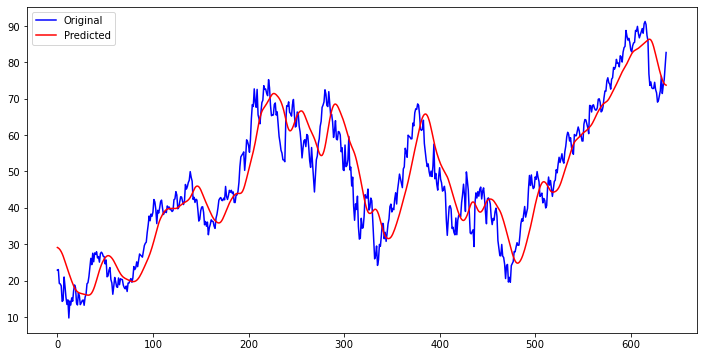

In [30]:
plt.figure(figsize=(12,6))
plt.plot(y_test, 'b', label = 'Original')
plt.plot(y_predicted, 'r', label = 'Predicted')
plt.legend()
plt.show()

##  

## Improving Previous Model

### To improve this, I will try to train another model that predicts 2 days ahead

In [148]:
df.shape

(3438, 5)

In [149]:
# Splitting our data into training and testing sets
closing_data = pd.DataFrame(df['Close'])
closing_data.head()
testing_df = closing_data.tail(638)
training_df = closing_data.head(2800)

print(training_df.shape)
print(testing_df.shape)

(2800, 1)
(638, 1)


In [150]:
# Defining a scaler and normalizing our data
scaler = MinMaxScaler(feature_range=(0,1))
training_array = scaler.fit_transform(training_df)

# We are adding a new variable here 'm', 'm' tells how many MORE days to predicts
x_train = []
y_train = []
n = 128
m = 1

# Creating the training data valid for training
for i in range(n+m,training_array.shape[0]):
    x_train.append(training_array[i-n-m:i-m])
    y_train.append(training_array[i-m:i+1])
x_train, y_train = np.array(x_train), np.array(y_train)

In [151]:
x_train.shape

(2671, 128, 1)

In [152]:
y_train.shape

(2671, 2, 1)

In [153]:
# We will be using the same machine learning model structure

model = Sequential()

model.add(LSTM(units = 32, activation='relu', return_sequences= True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 64, activation='relu', return_sequences= True))
model.add(Dropout(0.3))

model.add(LSTM(units = 96, activation='relu', return_sequences= True))
model.add(Dropout(0.3))

model.add(LSTM(units = 128, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(units=2))

In [154]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 128, 32)           4352      
                                                                 
 dropout_12 (Dropout)        (None, 128, 32)           0         
                                                                 
 lstm_13 (LSTM)              (None, 128, 64)           24832     
                                                                 
 dropout_13 (Dropout)        (None, 128, 64)           0         
                                                                 
 lstm_14 (LSTM)              (None, 128, 96)           61824     
                                                                 
 dropout_14 (Dropout)        (None, 128, 96)           0         
                                                                 
 lstm_15 (LSTM)              (None, 128)              

In [156]:
# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Training our model using our training data
model.fit(x_train, y_train, epochs=25, verbose=1)    # Note: it took around 25 epochs to nearly get to the current loss

Epoch 1/25
84/84 [==============================] - 29s 282ms/step - loss: 0.0269
Epoch 2/25
84/84 [==============================] - 24s 289ms/step - loss: 0.0032
Epoch 3/25
84/84 [==============================] - 24s 287ms/step - loss: 0.0025
Epoch 4/25
84/84 [==============================] - 24s 287ms/step - loss: 0.0024
Epoch 5/25
84/84 [==============================] - 24s 289ms/step - loss: 0.0021
Epoch 6/25
84/84 [==============================] - 25s 300ms/step - loss: 0.0020
Epoch 7/25
84/84 [==============================] - 25s 301ms/step - loss: 0.0023
Epoch 8/25
84/84 [==============================] - 25s 301ms/step - loss: 0.0018
Epoch 9/25
84/84 [==============================] - 26s 306ms/step - loss: 0.0020
Epoch 10/25
84/84 [==============================] - 26s 308ms/step - loss: 0.0017
Epoch 11/25
84/84 [==============================] - 26s 314ms/step - loss: 0.0017
Epoch 12/25
84/84 [==============================] - 26s 315ms/step - loss: 0.0017
Epoch 13/25
8

In [157]:
# Saving the trained model
model.save('keras_model2.h5')

In [158]:
# Factoring in the past 'n' days to utilize all of testing data
past_nm_days = training_df.tail(n+m)
final_df = past_nm_days.append(testing_df, ignore_index=True)
final_df.shape

C:\Users\jaing\AppData\Local\Temp\ipykernel_24008\4008679558.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = past_nm_days.append(testing_df, ignore_index=True)


(767, 1)

In [159]:
testing_array = scaler.fit_transform(final_df)
testing_array

array([[0.08795222],
       [0.08684906],
       [0.08361926],
       [0.09390016],
       [0.09546104],
       [0.12310103],
       [0.18871534],
       [0.20472879],
       [0.19361364],
       [0.21188767],
       [0.19560515],
       [0.19342525],
       [0.23898925],
       [0.29432291],
       [0.26439532],
       [0.15114448],
       [0.15200565],
       [0.06437619],
       [0.1128203 ],
       [0.07158909],
       [0.05554889],
       [0.09172018],
       [0.09365792],
       [0.05694823],
       [0.03767848],
       [0.        ],
       [0.03487965],
       [0.05350345],
       [0.00301423],
       [0.01485601],
       [0.05856321],
       [0.08741398],
       [0.07804827],
       [0.09656445],
       [0.1071146 ],
       [0.06652917],
       [0.10399267],
       [0.06803653],
       [0.08870595],
       [0.08752151],
       [0.10905218],
       [0.18903844],
       [0.15351302],
       [0.15448189],
       [0.14931451],
       [0.13112117],
       [0.09839475],
       [0.114

In [160]:
# Conducting the same preprocessing steps for testing data
x_test = []
y_test = []

for i in range(n+m,testing_array.shape[0]):
    x_test.append(testing_array[i-n-m:i-m])
    y_test.append(testing_array[i-m:i+1])
    
x_test, y_test = np.array(x_test), np.array(y_test)
print(x_test.shape)
print(y_test.shape)

(638, 128, 1)
(638, 2, 1)


In [161]:
# Predicting data
y_predicted = model.predict(x_test)

20/20 [==============================] - 2s 84ms/step


In [162]:
y_predicted.shape

(638, 2)

In [163]:
# Reversing the normalization we performed earlier on the predicted values 
scale_factor = 1 / scaler.scale_[0]
y_predicted = y_predicted * scale_factor
testing_array = testing_array * scale_factor

In [164]:
y_predicted

array([[25.681961, 25.764606],
       [25.659128, 25.73536 ],
       [25.582787, 25.651245],
       ...,
       [69.10731 , 68.928024],
       [68.46008 , 68.28631 ],
       [67.92208 , 67.7565  ]], dtype=float32)

In [165]:
y_first = y_predicted[:,0]
y_second = y_predicted[:,1]

In [166]:
y_second

array([25.764606 , 25.73536  , 25.651245 , 25.50768  , 25.297089 ,
       25.015825 , 24.665205 , 24.243008 , 23.752777 , 23.217009 ,
       22.659367 , 22.09501  , 21.530182 , 20.971046 , 20.402166 ,
       19.808445 , 19.188938 , 18.567167 , 17.95374  , 17.37576  ,
       16.847698 , 16.384077 , 15.990315 , 15.663571 , 15.397476 ,
       15.182582 , 15.009331 , 14.866769 , 14.7460375, 14.640721 ,
       14.544874 , 14.45699  , 14.379041 , 14.316425 , 14.279083 ,
       14.278067 , 14.325547 , 14.437798 , 14.627968 , 14.919697 ,
       15.324899 , 15.844955 , 16.470415 , 17.179285 , 17.934446 ,
       18.695436 , 19.427124 , 20.108852 , 20.732056 , 21.293402 ,
       21.79018  , 22.221437 , 22.58269  , 22.873777 , 23.085888 ,
       23.212597 , 23.25676  , 23.229485 , 23.137188 , 22.98489  ,
       22.772186 , 22.505377 , 22.200304 , 21.872856 , 21.535297 ,
       21.19673  , 20.869152 , 20.560093 , 20.277294 , 20.026144 ,
       19.808453 , 19.620214 , 19.455105 , 19.305864 , 19.1675

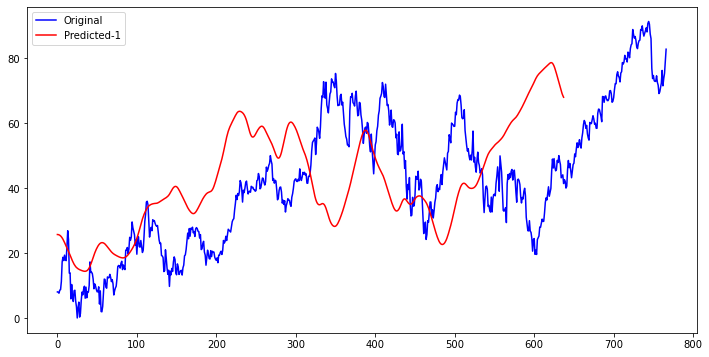

In [168]:
plt.figure(figsize=(12,6))
plt.plot(testing_array, 'b', label = 'Original')
plt.plot(y_first, 'r', label = 'Predicted-1')
# plt.plot(y_second, 'g', label = 'Predicted-2')
plt.legend()
plt.show()

## I need to revise my technique as it is clearly not effective